## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# for missing value imputation
from sklearn.impute import SimpleImputer

# feature scaling and one-hot-encoding
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   cabin     295 non-null    object 
 8   embarked  1307 non-null   object 
 9   title     1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB


In [11]:
vars_num = [var for var in data.columns if data[var].dtype != 'O' and var != target]
vars_cat = [var for var in data.columns if data[var].dtype == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print(vars_num)
print('Number of categorical variables: {}'.format(len(vars_cat)))
print(vars_cat)

Number of numerical variables: 5
['pclass', 'age', 'sibsp', 'parch', 'fare']
Number of categorical variables: 4
['sex', 'cabin', 'embarked', 'title']


### Find missing values in variables

In [12]:
# first in numerical variables
missing_vars_num = []
for var in vars_num:
    if data[var].isna().sum() != 0:
        missing_vars_num.append(var)
        print('{0}: {1}% of values missing'.format(var, round(100*data[var].isna().sum()/len(data[var]), 3)))

age: 20.092% of values missing
fare: 0.076% of values missing


In [13]:
# now in categorical variables
missing_vars_cat = []
for var in vars_cat:
    if data[var].isna().sum() != 0:
        missing_vars_cat.append(var)
        print('{0}: {1}% of values missing'.format(var, round(100*data[var].isna().sum()/len(data[var]), 3)))

cabin: 77.464% of values missing
embarked: 0.153% of values missing


### Determine cardinality of categorical variables

In [14]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

array([[<AxesSubplot:title={'center':'pclass'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'sibsp'}>,
        <AxesSubplot:title={'center':'parch'}>],
       [<AxesSubplot:title={'center':'fare'}>, <AxesSubplot:>]],
      dtype=object)

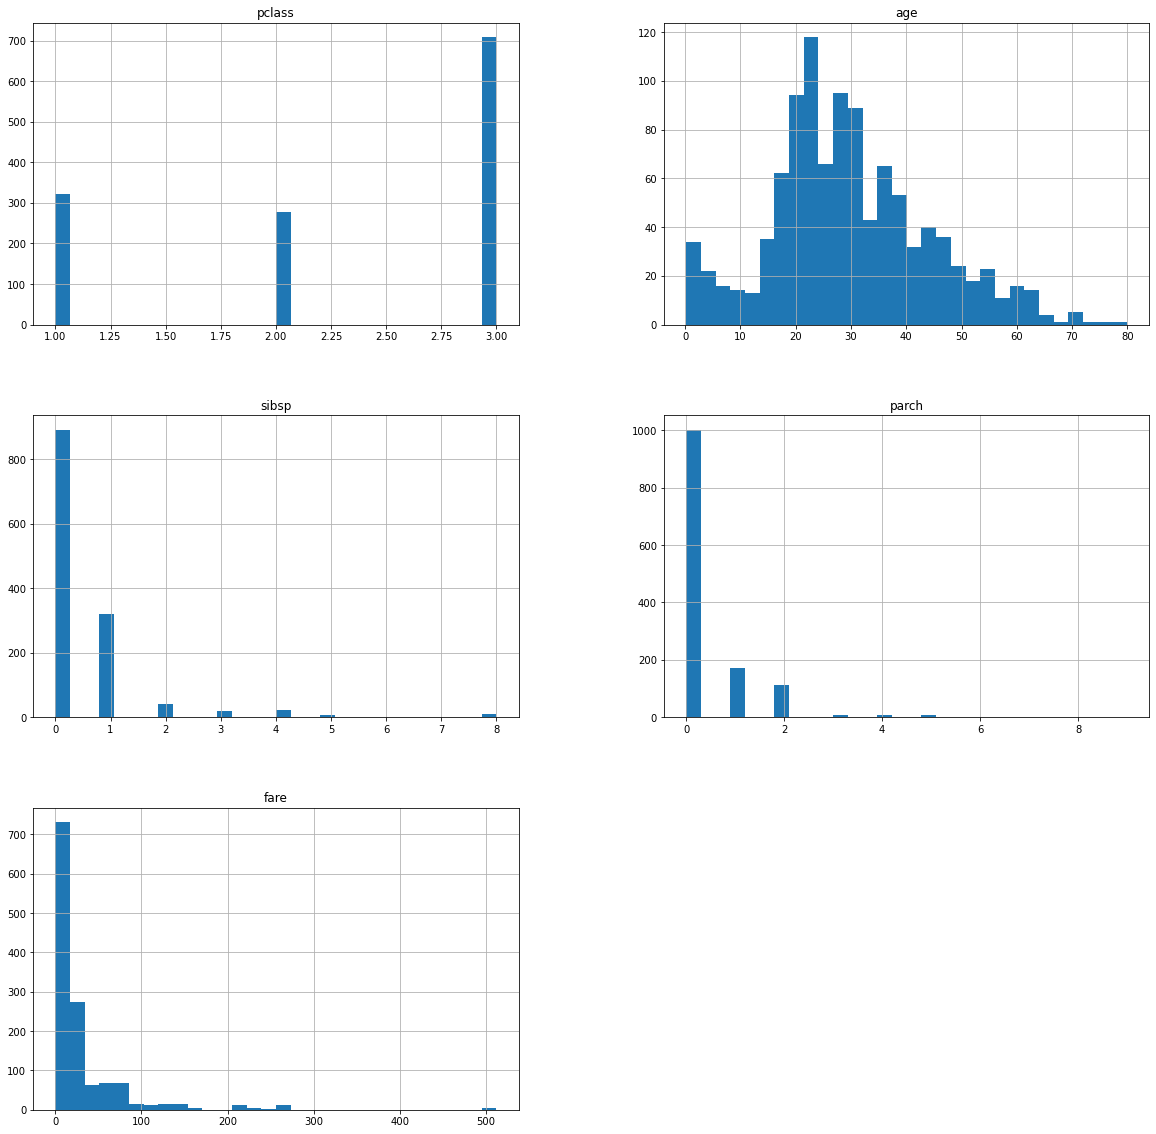

In [15]:
data[vars_num].hist(bins=30, figsize=(20,20))

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [120]:
# check if there are any cabins with a number as the first character
print('Number of cabins not fitting required format: {0}'.format(len(X_train.iloc[np.where(X_train['cabin'].str.match('^\d') & ~X_train['cabin'].isna())[0]])))
print('Number of cabins not fitting required format: {0}'.format(len(X_test.iloc[np.where(X_test['cabin'].str.match('^\d') & ~X_test['cabin'].isna())[0]])))

Number of cabins not fitting required format: 0
Number of cabins not fitting required format: 0


In [121]:
X_train['cabin'] = X_train['cabin'].str[0]
X_test['cabin'] = X_test['cabin'].str[0]
print(X_train['cabin'])

1118    NaN
44        E
1072    NaN
1130    NaN
574     NaN
       ... 
763     NaN
835     NaN
1216    NaN
559     NaN
684     NaN
Name: cabin, Length: 1047, dtype: object


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [122]:
# Add binary missing indicators for the missing numerical variables
print('Numerical variables with missing values: {0}'.format(missing_vars_num))
for var in missing_vars_num:
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
print('- Missing indicator added.')
X_train

Numerical variables with missing values: ['age', 'fare']
- Missing indicator added.


,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0000,0,0,7.9250,NaN,S,Mr,0,0
44,1,female,41.0000,0,0,134.5000,E,C,Miss,0,0
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr,1,0
1130,3,female,18.0000,0,0,7.7750,NaN,S,Miss,0,0
574,2,male,29.0000,1,0,21.0000,NaN,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,NaN,S,Miss,0,0
835,3,male,NaN,0,0,8.0500,NaN,S,Mr,1,0
1216,3,female,NaN,0,0,7.7333,NaN,Q,Miss,1,0
559,2,female,20.0000,0,0,36.7500,NaN,S,Miss,0,0


In [123]:
# Impute the missing numerical values with the column's median. Save the imputers for use in the testing.
for var in missing_vars_num:
    median_imputer = SimpleImputer(strategy='median')
    X_train[var] = median_imputer.fit_transform(X_train[[var]])
    joblib.dump(median_imputer, var+'_median_imputer.joblib')
    X_test[var] = median_imputer.transform(X_test[[var]])
print('Median imputation completed.')
X_test

Median imputation completed.


,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1139,3,male,38.0,0,0,7.8958,NaN,S,Mr,0,0
533,2,female,21.0,0,1,21.0000,NaN,S,Miss,0,0
459,2,male,42.0,1,0,27.0000,NaN,S,Mr,0,0
1150,3,male,28.0,0,0,14.5000,NaN,S,Mr,1,0
393,2,male,25.0,0,0,31.5000,NaN,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
753,3,male,22.0,0,0,8.0500,NaN,S,Mr,0,0
1052,3,male,28.0,0,0,7.8958,NaN,S,Mr,1,0
426,2,male,30.0,0,0,13.0000,NaN,S,Mr,0,0
554,2,male,26.0,0,0,13.0000,NaN,S,Mr,0,0


### Replace Missing data in categorical variables with the string **Missing**

In [124]:
print('Categorical variables with missing values: {0}'.format(missing_vars_cat))
X_train[missing_vars_cat] = X_train[missing_vars_cat].fillna(value='missing')
X_test[missing_vars_cat] = X_test[missing_vars_cat].fillna(value='missing')
X_train

Categorical variables with missing values: ['cabin', 'embarked']


,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0000,0,0,7.9250,missing,S,Mr,0,0
44,1,female,41.0000,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0000,0,0,7.7333,missing,Q,Mr,1,0
1130,3,female,18.0000,0,0,7.7750,missing,S,Miss,0,0
574,2,male,29.0000,1,0,21.0000,missing,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,missing,S,Miss,0,0
835,3,male,28.0000,0,0,8.0500,missing,S,Mr,1,0
1216,3,female,28.0000,0,0,7.7333,missing,Q,Miss,1,0
559,2,female,20.0000,0,0,36.7500,missing,S,Miss,0,0


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [125]:
for var in vars_cat:
    label_percentages = (X_train[var].value_counts() / len(X_train))
    rare_labels = label_percentages[label_percentages < 0.05].index
    print('Rare labels: {0}'.format(rare_labels))
    X_train[var].replace(to_replace=rare_labels, value='rare', inplace=True)
    X_test[var].replace(to_replace=rare_labels, value='rare', inplace=True)
    print('\nAfter replacing of rare labels:\n')
    print(X_train[var].value_counts() / len(X_train))
X_train

Rare labels: Index([], dtype='object')

After replacing of rare labels:

male      0.633238
female    0.366762
Name: sex, dtype: float64
Rare labels: Index(['B', 'E', 'D', 'A', 'F', 'G', 'T'], dtype='object')

After replacing of rare labels:

missing    0.766953
rare       0.158548
C          0.074499
Name: cabin, dtype: float64
Rare labels: Index(['missing'], dtype='object')

After replacing of rare labels:

S       0.709647
C       0.195798
Q       0.092646
rare    0.001910
Name: embarked, dtype: float64
Rare labels: Index(['Master', 'Other'], dtype='object')

After replacing of rare labels:

Mr      0.569245
Miss    0.200573
Mrs     0.159503
rare    0.070678
Name: title, dtype: float64


,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0000,0,0,7.9250,missing,S,Mr,0,0
44,1,female,41.0000,0,0,134.5000,rare,C,Miss,0,0
1072,3,male,28.0000,0,0,7.7333,missing,Q,Mr,1,0
1130,3,female,18.0000,0,0,7.7750,missing,S,Miss,0,0
574,2,male,29.0000,1,0,21.0000,missing,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,missing,S,Miss,0,0
835,3,male,28.0000,0,0,8.0500,missing,S,Mr,1,0
1216,3,female,28.0000,0,0,7.7333,missing,Q,Miss,1,0
559,2,female,20.0000,0,0,36.7500,missing,S,Miss,0,0


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [126]:
X_train_cat_encoded = pd.get_dummies(X_train[vars_cat], prefix=vars_cat, drop_first=True)
X_train = pd.concat([X_train, X_train_cat_encoded], axis=1)

X_test_cat_encoded = pd.get_dummies(X_test[vars_cat], prefix=vars_cat, drop_first=True)
X_test = pd.concat([X_test, X_test_cat_encoded], axis=1)

In [127]:
# Drop the columns
X_train.drop(columns=vars_cat, inplace=True)
X_test.drop(columns=vars_cat, inplace=True)
X_train

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_missing,cabin_rare,embarked_Q,embarked_S,embarked_rare,title_Mr,title_Mrs,title_rare
1118,3,25.0000,0,0,7.9250,0,0,1,1,0,0,1,0,1,0,0
44,1,41.0000,0,0,134.5000,0,0,0,0,1,0,0,0,0,0,0
1072,3,28.0000,0,0,7.7333,1,0,1,1,0,1,0,0,1,0,0
1130,3,18.0000,0,0,7.7750,0,0,0,1,0,0,1,0,0,0,0
574,2,29.0000,1,0,21.0000,0,0,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3,0.1667,1,2,20.5750,0,0,0,1,0,0,1,0,0,0,0
835,3,28.0000,0,0,8.0500,1,0,1,1,0,0,1,0,1,0,0
1216,3,28.0000,0,0,7.7333,1,0,0,1,0,1,0,0,0,0,0
559,2,20.0000,0,0,36.7500,0,0,0,1,0,0,1,0,0,0,0


In [128]:
X_train.shape, X_test.shape

((1047, 16), (262, 15))

In [130]:
# Notice that we have a different number of columns in the test set. We need to add the missing column to
# the test set. It is embarked_rare
X_test.insert(12, column='embarked_rare', value=0)
X_test

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_missing,cabin_rare,embarked_Q,embarked_S,embarked_rare,title_Mr,title_Mrs,title_rare
1139,3,38.0,0,0,7.8958,0,0,1,1,0,0,1,0,1,0,0
533,2,21.0,0,1,21.0000,0,0,0,1,0,0,1,0,0,0,0
459,2,42.0,1,0,27.0000,0,0,1,1,0,0,1,0,1,0,0
1150,3,28.0,0,0,14.5000,1,0,1,1,0,0,1,0,1,0,0
393,2,25.0,0,0,31.5000,0,0,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,3,22.0,0,0,8.0500,0,0,1,1,0,0,1,0,1,0,0
1052,3,28.0,0,0,7.8958,1,0,1,1,0,0,1,0,1,0,0
426,2,30.0,0,0,13.0000,0,0,1,1,0,0,1,0,1,0,0
554,2,26.0,0,0,13.0000,0,0,1,1,0,0,1,0,1,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [131]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'StandardScaler.joblib')

['StandardScaler.joblib']

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [134]:
log_reg = LogisticRegression(C=0.0005, random_state=0)

log_reg.fit(X=X_train, y=y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [141]:
# Training set predictions and performance:
print('Training performance\n')
pred_class = log_reg.predict(X_train)
print('First five class predictions: {}'.format(pred_class[:5]))
pred_prob = log_reg.predict_proba(X_train)[:,1]
print('First five class probability predictions: {}'.format(pred_prob[:5]))

print('ROC AUC Score: {}'.format(roc_auc_score(y_train, pred_prob)))
print('Accuracy Score: {}'.format(accuracy_score(y_train, pred_class)))

print('\n################\n\nTest Performance\n')
pred_class = log_reg.predict(X_test)
print('First five class predictions: {}'.format(pred_class[:5]))
pred_prob = log_reg.predict_proba(X_test)[:,1]
print('First five class probability predictions: {}'.format(pred_prob[:5]))

print('ROC AUC Score: {}'.format(roc_auc_score(y_test, pred_prob)))
print('Accuracy Score: {}'.format(accuracy_score(y_test, pred_class)))

Training performance

First five class predictions: [0 1 0 0 0]
First five class probability predictions: [0.30899101 0.53891001 0.30907666 0.40545345 0.32225307]
ROC AUC Score: 0.8431723338485316
Accuracy Score: 0.7125119388729704

################

Test Performance

First five class predictions: [0 0 0 0 0]
First five class probability predictions: [0.30715281 0.42633648 0.32143779 0.29705426 0.32805546]
ROC AUC Score: 0.8354012345679012
Accuracy Score: 0.7022900763358778


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**